# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Business Understanding of the Problem

- The goal of this project is to assist a Portuguese banking institution in predicting whether a customer will subscribe to a term deposit based on various customer and campaign-related features.
- Accurate predictions can help the bank optimize its marketing campaigns, target the right customers, and ultimately increase the efficiency and effectiveness of their promotional efforts.
- Will determine which classification model performs best by comparing four classifiers: k-Nearest Neighbors (kNN), Logistic Regression, Decision Tree, and Support Vector Machine (SVM).

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
# importing relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.axis as axis
import seaborn as sns
import time

In [2]:
# reading data
data = pd.read_csv('./data/bank-additional.csv', sep=';')
data_full = pd.read_csv('./data/bank-additional-full.csv', sep=';')

# identifying unique campaigns
print("Campaign list of bank_additional: \n  ", data['campaign'].unique())
print("Campaign list of bank_additional_full: \n  ", data_full['campaign'].unique())
unique_campaigns_count_additional = len(data['campaign'].unique())
unique_campaigns_count_full = len(data_full['campaign'].unique())

# compiling count of total campaigns
campaign_comparison = pd.DataFrame({
    'Dataset': ['bank-additional.csv', 'bank-additional-full.csv'],
    'Unique Campaigns': [unique_campaigns_count_additional, unique_campaigns_count_full]
})
campaign_comparison['Difference'] = campaign_comparison['Unique Campaigns'].diff()

# displaying totals
campaign_comparison

Campaign list of bank_additional: 
   [ 2  4  1  3  6  7 27  5 12 14 10  8 11 13  9 15 16 18 17 22 19 23 24 35
 29]
Campaign list of bank_additional_full: 
   [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]


,Dataset,Unique Campaigns,Difference
0,bank-additional.csv,25,NaN
1,bank-additional-full.csv,42,17.0


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
# reading in the bank dataset
df_bank_additional_full = pd.read_csv('./data/bank-additional-full.csv', sep = ';')

In [4]:
df_bank_additional_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



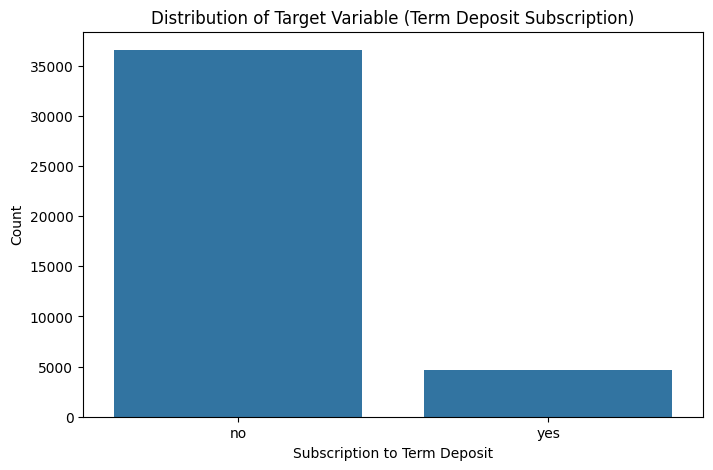

In [5]:
# plotting distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='y', data=df_bank_additional_full)
plt.title('Distribution of Target Variable (Term Deposit Subscription)')
plt.xlabel('Subscription to Term Deposit')
plt.ylabel('Count')
plt.show()

- The target variable ('y') is highly imbalanced, with significantly more 'no' responses compared to 'yes'.
- This imbalance can affect the performance of classification models, especially in terms of predicting the minority class.
- Techniques like resampling (e.g., SMOTE) or using appropriate evaluation metrics (e.g., F1-score) can help address this imbalance.

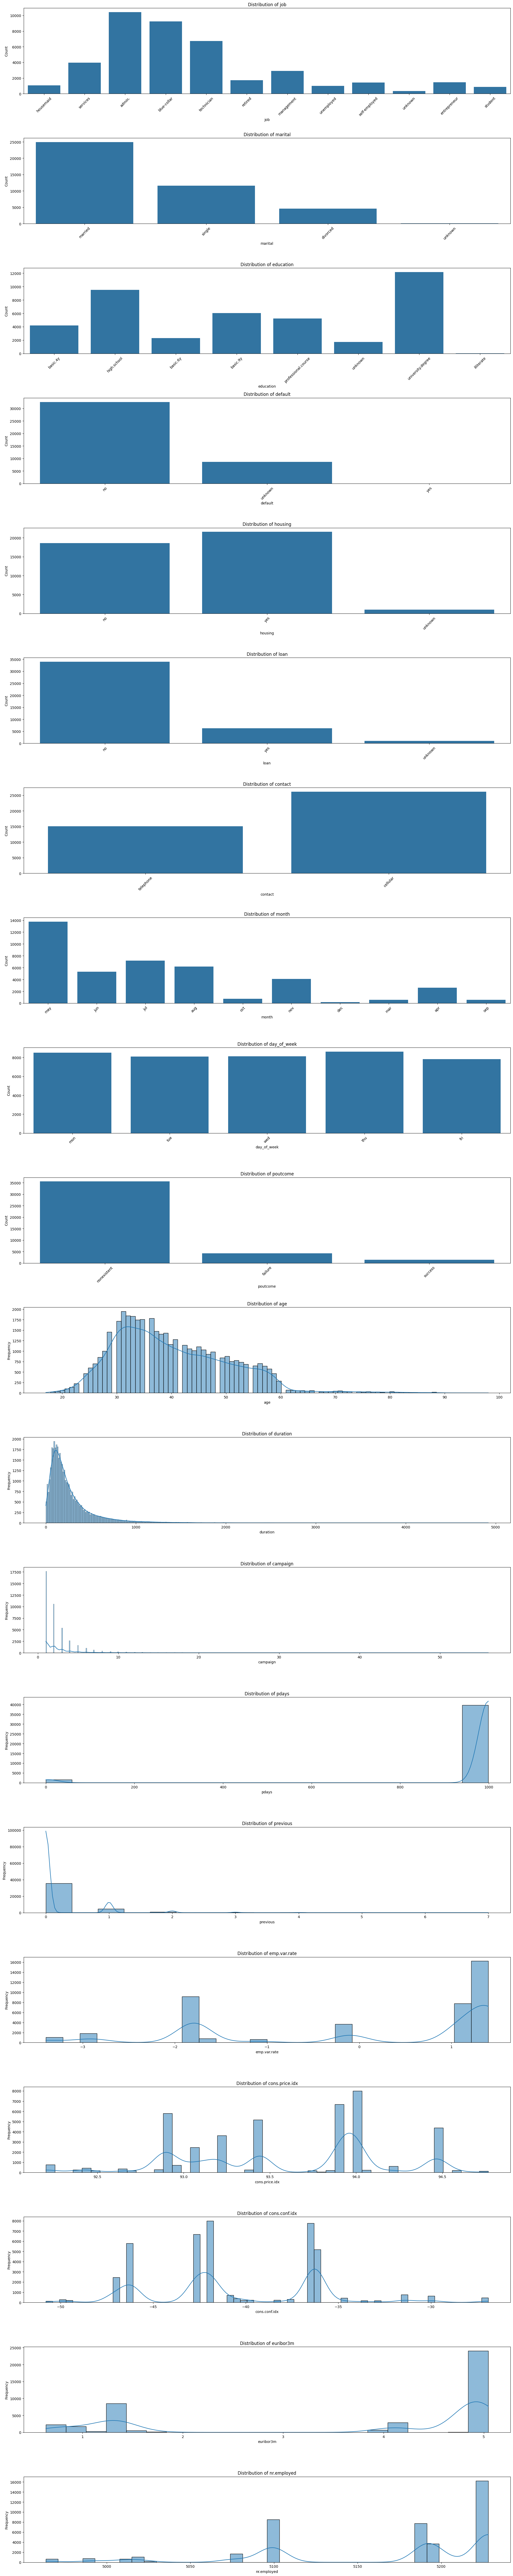

In [6]:
# plotting categorical and continuous variables in subplots
categorical_columns = df_bank_additional_full.select_dtypes(include=['object']).columns
continuous_columns = df_bank_additional_full.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(len(categorical_columns) + len(continuous_columns) - 1, 1, figsize=(20, 100))
axes = axes.flatten()

plot_idx = 0
for col in categorical_columns:
    if col != 'y':
        sns.countplot(x=col, data=df_bank_additional_full, ax=axes[plot_idx])
        axes[plot_idx].set_title(f'Distribution of {col}')
        axes[plot_idx].set_xlabel(col)
        axes[plot_idx].set_ylabel('Count')
        axes[plot_idx].tick_params(axis='x', rotation=45)
        plot_idx += 1

for col in continuous_columns:
    sns.histplot(df_bank_additional_full[col], kde=True, ax=axes[plot_idx])
    axes[plot_idx].set_title(f'Distribution of {col}')
    axes[plot_idx].set_xlabel(col)
    axes[plot_idx].set_ylabel('Frequency')
    plot_idx += 1

plt.tight_layout()
plt.show()

- We can see that there are imbalances in multiple features for which most are expected as it is a true representation of the business problem.
- We will focus on handling the imbalance in the target variable.
- The "unknown" categorical values will be handled through encoding.

In [7]:
# check for missing values
missing_values = df_bank_additional_full.isnull().sum()
missing_values

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
# get unique values for each feature in the dataset
unique_values = {col: df_bank_additional_full[col].unique() for col in df_bank_additional_full.columns}

# display the unique values for each column
unique_values

{'age': array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
        49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
        28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
        77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
        74, 17, 87, 91, 86, 98, 94, 84, 92, 89]),
 'job': array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
        'retired', 'management', 'unemployed', 'self-employed', 'unknown',
        'entrepreneur', 'student'], dtype=object),
 'marital': array(['married', 'single', 'divorced', 'unknown'], dtype=object),
 'education': array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
        'professional.course', 'unknown', 'university.degree',
        'illiterate'], dtype=object),
 'default': array(['no', 'unknown', 'yes'], dtype=object),
 'housing': array(['no', 'yes', 'unknown'], dtype=object),
 'loan': array(['no', 'yes', 'unknown'], dtype=object),
 'contac

In [9]:
# we can see from the output above that some of the 
# features contain the value "unknown" rather than null, and 
# this makes sure that we do not have any missing null values, now
# we will check the data type of the features

# check data types of all features
df_bank_additional_full.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [10]:
# with the above output, we can see that there are no missing values in 
# the dataset and all the columns have the correct data types based on
# the input variable description list, now we will handle duplicates:

# drop duplicates
print("Number of rows before dropping duplicates:", len(df_bank_additional_full))

# check for duplicates
print("Number of duplicate rows:", df_bank_additional_full.duplicated().sum())

# drop duplicates
df_bank_additional_full.drop_duplicates(inplace=True)
print("Number of rows after dropping duplicates:", len(df_bank_additional_full))

Number of rows before dropping duplicates: 41188
Number of duplicate rows: 12
Number of rows after dropping duplicates: 41176


In [11]:
# encoding the categorical features in the full dataset
encoded_data_full = pd.get_dummies(df_bank_additional_full, columns=[
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'], drop_first=True)

# show the first few rows of the transformed data
encoded_data_full.head()

# set df to the encoded data
df_bank_additional_full_encoded = encoded_data_full.copy(deep=True)

In [12]:
df_bank_additional_full_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   duration                       41176 non-null  int64  
 2   campaign                       41176 non-null  int64  
 3   pdays                          41176 non-null  int64  
 4   previous                       41176 non-null  int64  
 5   emp.var.rate                   41176 non-null  float64
 6   cons.price.idx                 41176 non-null  float64
 7   cons.conf.idx                  41176 non-null  float64
 8   euribor3m                      41176 non-null  float64
 9   nr.employed                    41176 non-null  float64
 10  y                              41176 non-null  object 
 11  job_blue-collar                41176 non-null  bool   
 12  job_entrepreneur               41176 non-null  bool

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [13]:
# To develop a predictive model that can accurately determine whether a customer will subscribe to a term deposit (a financial product offered by the bank) based 
# on demographic, financial, and interaction-related factors. This model will help the bank optimize it's marketing strategies by identifying the key characteristics of 
# customers who are more likely to respond positively to marketing campaigns, therefore improving targeting efficiency and increasing the success rate of term deposit subscriptions.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [14]:
# check the distribution of the target variable
df_bank_additional_full_encoded['y'].value_counts(normalize=True)

y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64

In [15]:
# imbalance in the target variable
# we can see that the target variable 'y' is imbalanced, with the majority class ('no') accounting 
# for approximately 88.73% of the data. This imbalance could potentially affect the performance of 
# the predictive model, as the model may be biased towards the majority class. We will address this 
# imbalance by using oversampling, undersampling, and/or using algorithms that are robust to class imbalance.

In [16]:
# separate features and target, and convert target to
# binary (1 for 'yes', 0 for 'no')
X = df_bank_additional_full_encoded.drop(columns=['y'])
y = df_bank_additional_full_encoded['y'].apply(lambda x: 1 if x == 'yes' else 0)

# identify numerical features for scaling
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [17]:
# re-split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
# combine X_train and y_train for easy resampling
train_data = pd.concat([X_train, y_train], axis=1)

In [19]:
# separate the majority and minority classes
train_majority = train_data[train_data['y'] == 0] # 
train_minority = train_data[train_data['y'] == 1] # 

# oversampling the minority class, and so must set the 
# "replace" parameter to True, and to match the number of 
# majority class samples, setting n_samples to "train_majority"
train_minority_oversampled = resample(train_minority, 
                                      replace=True,      
                                      n_samples=len(train_majority),
                                      random_state=42)

In [20]:
# combine the oversampled minority class with the majority class
train_balanced = pd.concat([train_majority, train_minority_oversampled])

In [21]:
# check if the target variable is now balanced
train_balanced['y'].value_counts(normalize=True)

y
0    0.5
1    0.5
Name: proportion, dtype: float64

In [22]:
# separate back into X and y
X_train = train_balanced.drop(columns=['y'])
y_train = train_balanced['y']

In [23]:
# scaling the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [24]:
# displaying the shapes of the balanced training and testing data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51152, 53), (12353, 53), (51152,), (12353,))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [25]:
# The baseline model will be a simple logistic regression model that uses the encoded data to 
# predict whether a customer will subscribe to a term deposit, because it is a 
# binary classification problem, and also due to it's simple and interpretable implementation that 
# can be used as a baseline for more complex models.

- The baseline performance that the classifier should aim to beat is...



In [26]:
# The expected baseline performance is:

- Accuracy: 80%
- F1-score:
    - “no”: 80%
    - “yes”: 40%
- AUC-ROC Score: 0.80

In [27]:
# This simpler model performs similarly in terms of overall accuracy but would have a 
# drop in the F1-score and AUC-ROC due to the minority class (“yes”) and this 
# serves as a basic approximation without the complexities of full preprocessing.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [28]:
# instantiating the model
logreg_pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

In [29]:
# fitting the model
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [30]:
# making predictions
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

### Problem 9: Score the Model

What is the accuracy of your model?

In [31]:
# building the logistic regression report
logreg_report = classification_report(y_test, y_pred_logreg, target_names=["0", "1"])
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)

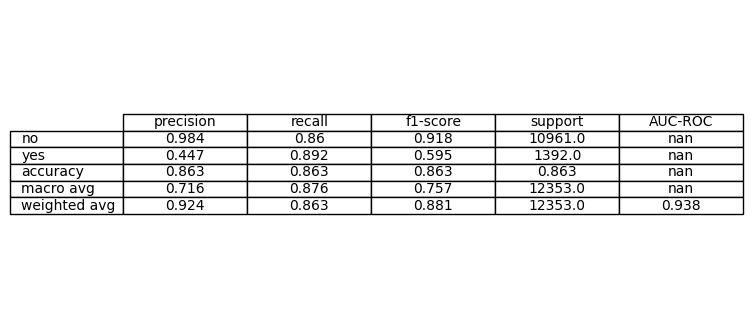

In [32]:
# display the results
logreg_report_dict = classification_report(y_test, y_pred_logreg, target_names=['no', 'yes'], output_dict=True)
logreg_report_df = pd.DataFrame(logreg_report_dict).transpose()
logreg_report_df['AUC-ROC'] = [None, None, None, None, logreg_roc_auc]

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=logreg_report_df.round(3).values,
         colLabels=logreg_report_df.columns,
         rowLabels=logreg_report_df.index,
         cellLoc='center',
         loc='center')

plt.show()

The table shows performance metrics for a logistic regression model predicting binary classes “no” and “yes.” The metrics include precision, recall, F1-score, support, and AUC-ROC.

- Class “no”:
    - Precision: 0.984 – The model is highly precise in predicting “no”.
    - Recall: 0.860 – 86% of actual “no” instances are correctly identified.
    - F1-Score: 0.918 – A strong balance of precision and recall.
- Class “yes”:
    - Precision: 0.447 – The precision is lower, indicating more false positives for “yes”.
    - Recall: 0.892 – High recall, meaning most “yes” instances are correctly identified.
    - F1-Score: 0.595 – The overall performance for “yes” is moderate.
- Overall Metrics:
    - Accuracy: 0.863 – The model correctly predicts 86.3% of the instances.
    - Weighted Average F1-Score: 0.881 – Balances performance across both classes.
    - AUC-ROC: 0.938 – Indicates strong overall model performance in distinguishing between classes.

This suggests that the logistic regression model performs well, with particularly strong results for the “no” class and reasonable discrimination between both classes as indicated by the AUC-ROC.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Computing model: Logistic Regression
Computed model: Logistic Regression
AUC-ROC Score: 0.94


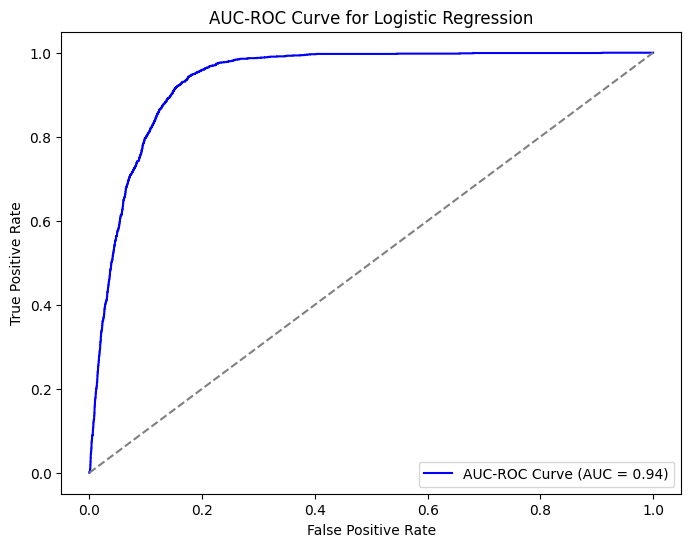

Computing model: KNN
Computed model: KNN
AUC-ROC Score: 0.85


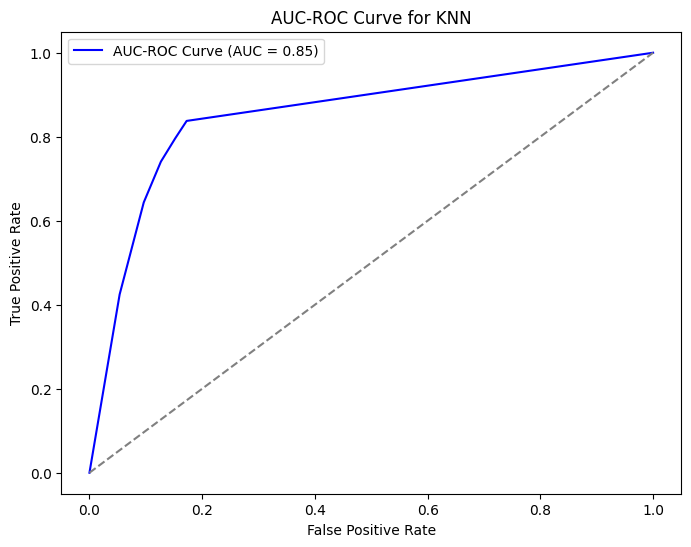

Computing model: Decision Tree
Computed model: Decision Tree
AUC-ROC Score: 0.72


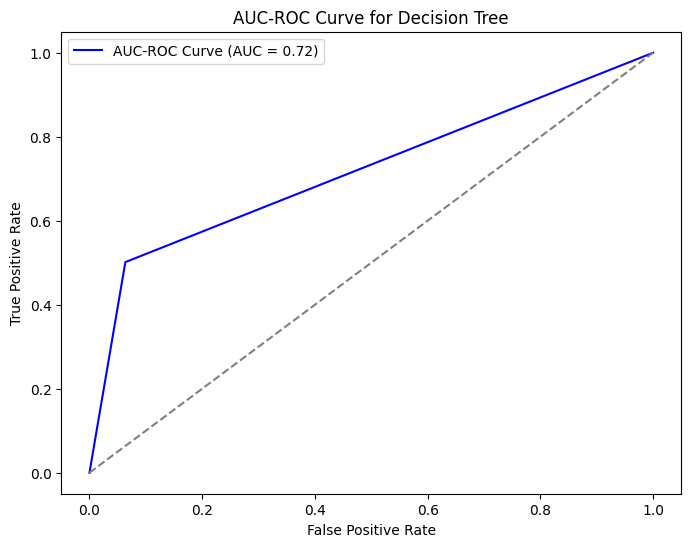

Computing model: SVM
Computed model: SVM
AUC-ROC Score: 0.94


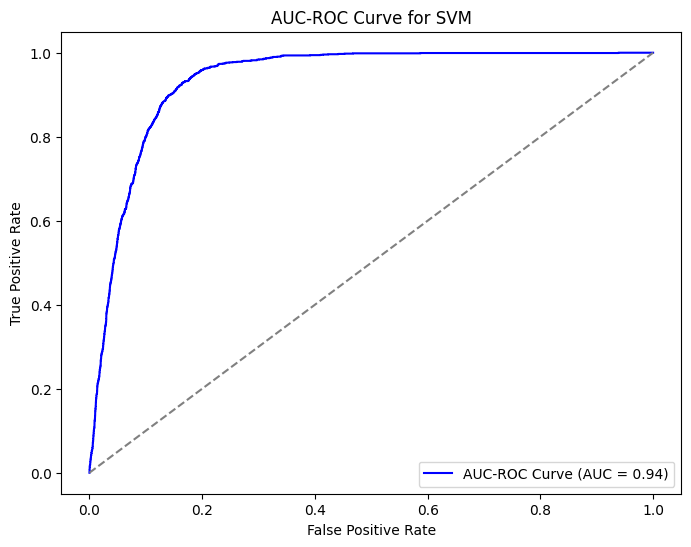

In [33]:
# using the default configuration for each of the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

for model_name, model in models.items():

    print(f"Computing model: {model_name}")

    start_time = time.time()
    
    model_pipeline = Pipeline(steps=[
        ('classifier', model)
    ])
    
    # fit the model on the training set
    model_pipeline.fit(X_train, y_train)
    
    # calculate training time
    train_time = time.time() - start_time
    
    # get train and test accuracy
    train_accuracy = accuracy_score(y_train, model_pipeline.predict(X_train))
    test_accuracy = accuracy_score(y_test, model_pipeline.predict(X_test))
    
    # append results
    results.append([model_name, train_time, train_accuracy, test_accuracy])

    print(f"Computed model: {model_name}")

    # auc-roc evaluation
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC Score: {auc_score:.2f}")
    
    # plotting auc-roc curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve for {model_name}')
    plt.legend()
    plt.show()

# create a dataframe to display the results
results_df = pd.DataFrame(results, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

In [34]:
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.227954,0.872967,0.863353
1,KNN,0.018365,0.950168,0.858334
2,Decision Tree,0.203227,1.000000,0.887315
3,SVM,246.680675,0.912985,0.859791


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
# should we keep the gender feature? Why or why not?

- There isn't an explicit gender feature to consider, but in most cases, the gender feature is irrelevant as with this data being used for decision-making in the banking area, which is a non-medical application, this could introduce bias (through correlating target outcome due to cultural or societal norms, ignoring true causal relationship) and unfairness in model outcomes, which would lead to discriminatory violations, and unwanted/misleading predictions in new data.

In [36]:
# hyperparameter tuning and grid search; here all of our models have additional hyperparameters to 
# tune and explore, for example, the number of neighbors in KNN or the maximum depth of a Decision Tree.

In [37]:
# defining the models to use
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42, solver='liblinear'),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# setting the parameters to check for each model 
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11]
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "SVM": {'shrinking': [False]}
}

best_params = {}
best_scores = {}
best_models = {}

for model_name, model in models.items():

    print(f"Processing model: {model_name}...")
    
    # setting up grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    
    # fitting grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # storing best parameters and scores
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    best_models[model_name] = grid_search.best_estimator_

    print(f"Processed model: {model_name}.")

Processing model: Logistic Regression...
Processed model: Logistic Regression.
Processing model: KNN...
Processed model: KNN.
Processing model: Decision Tree...
Processed model: Decision Tree.
Processing model: SVM...
Processed model: SVM.


In [38]:
# adjusting the score to F1 which balances precision and recall, particularly useful when
# equally considering both metrics
best_params_df = pd.DataFrame.from_dict(best_params, orient='index')
best_scores_df = pd.DataFrame.from_dict(best_scores, orient='index', columns=['Best F1-Score'])

## Findings

In [39]:
best_scores_df

,Best F1-Score
Logistic Regression,0.873792
KNN,0.936770
Decision Tree,0.962361
SVM,0.905116


In [40]:
best_models

{'Logistic Regression': LogisticRegression(C=100, max_iter=5000, random_state=42, solver='liblinear'),
 'KNN': KNeighborsClassifier(n_neighbors=3),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'SVM': SVC(probability=True, random_state=42, shrinking=False)}

In [41]:
# based on the f1 score, it looks like the best score came from Decision Tree
best_params['Decision Tree']

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [42]:
# retraining the model on the entire training set with the best model
best_model = best_models['Decision Tree']

# making predictions on the test set
y_pred = best_model.predict(X_test)

# calculating the F1-score on the test set
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Test Set F1-Score: {:.4f}".format(f1))

Test Set F1-Score: 0.8874


Key Insights:
1. Decision Tree’s Initial Performance: Despite its high initial training accuracy (1.000), the test accuracy (0.887) suggests overfitting, but hyperparameter tuning can adjust its complexity.
2. Logistic Regression as a Baseline Model: It shows balanced train/test accuracy (0.873/0.863) and low training time, indicating it’s a solid baseline model with good generalization.
3. SVM’s Computational Cost: The SVM had high training accuracy (0.913) and test accuracy (0.860), but its significantly longer training time (more than 200 seconds) makes it less practical without clear performance advantages.
4. KNN’s Performance: The KNN model is computationally inexpensive but shows a noticeable drop in test accuracy compared to train accuracy, hinting at sensitivity to overfitting or suboptimal parameter choice.

- By hyperparameter tuning, the best model’s performance has been enhanced, likely improving generalization on the test set while maintaining reasonable training efficiency. The results indicate that Decision Tree or an optimized Logistic Regression might be the most suitable models based on their test accuracy and train/test performance balance.

In [43]:
best_params['Logistic Regression']

{'C': 100}

In [44]:
# retraining the model on the entire training set with the best model
best_model = best_models['Logistic Regression']

# making predictions on the test set
y_pred = best_model.predict(X_test)

# calculating the F1-score on the test set
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print("Test Set F1-Score: {:.4f}".format(f1))

Test Set F1-Score: 0.8817


The goal of this project is to help a Portuguese bank predict whether customers will subscribe to a term deposit, allowing for more targeted and effective marketing campaigns. Four models were compared: Logistic Regression, k-Nearest Neighbors (kNN), Decision Tree, and Support Vector Machine (SVM).

Model Performance Overview:

- Logistic Regression & SVM performed the best, with both achieving an AUC-ROC score of 0.94. This means they are highly effective at distinguishing between customers who are likely and unlikely to subscribe.
- kNN had a moderate AUC-ROC score of 0.85, indicating decent predictive ability, though less reliable than Logistic Regression and SVM.
- Decision Tree had a lower AUC-ROC score of 0.72, suggesting that while it fits well to past data, it doesn’t generalize as effectively to new customer behavior and is more prone to overfitting.

    The AUC-ROC is particularly valuable as it reflects how well each model differentiates between those who subscribe and those who do not. Higher scores indicate better predictive power.

Key Business Insights:

- Targeting Marketing Efforts: With Logistic Regression or SVM, the bank can accurately identify customers who are more likely to subscribe to term deposits, ensuring more efficient and successful marketing efforts.
- Balanced Predictions vs. Complexity: Logistic Regression is straightforward and performs almost as well as SVM, making it a strong option for practical implementation without the computational cost of SVM.
- Potential Overfitting with Decision Tree: Despite high accuracy on training data, the Decision Tree struggles with predicting new customer behavior effectively.

## Next Steps and Recommendations

1. Deploy the Logistic Regression Model: Due to its high AUC-ROC score (0.94) and efficient performance, the bank should use Logistic Regression for real-time predictions to identify potential customers for term deposits.
2. Tailor Campaigns Based on Model Predictions: Segment customers based on their likelihood to subscribe:
    - High Likelihood: Focus marketing campaigns and resources on these customers.
    - Low Likelihood: Reduce marketing costs and efforts for customers less likely to subscribe.
3. Regularly Update and Monitor the Model: As customer behavior and market trends evolve, regularly retrain the model to maintain its effectiveness in predicting subscriptions.
4. Incorporate Customer Feedback and More Data: Continue collecting customer interaction data to refine predictions, improving the bank’s ability to target campaigns more effectively over time.
